In [1]:
import numpy as np
import pandas as pd
from pandas.io import gbq

import re

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn import cluster, metrics

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", palette="Set3")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [97]:
taxonomy_data_playlists = gbq.read_gbq('SELECT * FROM `umg-comm-tech-dev.playlist_sequencing.amplify_taxonomy_playlists`',
    project_id='umg-comm-tech-dev', dialect='standard')

In [5]:
taxonomy_data_tracks = gbq.read_gbq('SELECT * FROM `umg-comm-tech-dev.playlist_sequencing.amplify_taxonomy_tracks`',
    project_id='umg-comm-tech-dev', dialect='standard')

In [98]:
print(taxonomy_data_playlists.shape)
print(taxonomy_data_tracks.shape)

(403, 8)
(4011, 11)


In [99]:
taxonomy_data_playlists['lvl_3']=np.nan
taxonomy_data_playlists['lvl_4']=np.nan

taxonomy_data_playlists['source']='playlists'
taxonomy_data_tracks['source']='tracks'

taxonomy_data = pd.concat([taxonomy_data_playlists,taxonomy_data_tracks], ignore_index=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [100]:
taxonomy_data.head(10)

,description,lvl_0,lvl_1,lvl_2,lvl_3,lvl_4,name,path,source,taggable,taxonomynodeid
0,Sung Christian music with roots in traditional...,Genre,Gospel,None,NaN,NaN,Classic Gospel,Genre/Gospel/Classic Gospel,playlists,true,9e70e1a7-3e64-4704-9175-f5069732a97a
1,Characterized by a loose narrative lyrical sty...,Genre,None,None,NaN,NaN,Blues,Genre/Blues,playlists,true,e6576040-ba5a-4f51-b547-3d1ec7005afd
2,Traditional Western art music. Though wide-ran...,Genre,None,None,NaN,NaN,Classical,Genre/Classical,playlists,true,9d557d09-c923-410c-b2c9-3239d073d703
3,Characterized by the use of guitar and twangy ...,Genre,None,None,NaN,NaN,Country,Genre/Country,playlists,true,6dc2a882-8bf6-423e-a9e8-07615ac91154
4,Created primarily by electronic instruments an...,Genre,None,None,NaN,NaN,Electronic,Genre/Electronic,playlists,true,195e1e65-82e9-4a49-96de-fca22301027e
5,Refers both to the traditional folk music of t...,Genre,None,None,NaN,NaN,Folk,Genre/Folk,playlists,true,da8a990f-9398-483d-8284-80d01c4ef634
6,Sung Christian music with roots in traditional...,Genre,None,None,NaN,NaN,Gospel,Genre/Gospel,playlists,true,f814d27a-2e75-48a7-b2aa-731e6e0ac95a
7,Typically features rapped vocals (emphasis on ...,Genre,None,None,NaN,NaN,Hip-Hop,Genre/Hip-Hop,playlists,true,c9827769-5b34-4403-8921-eb103f322fbf
8,Wide-ranging genre characterized by the use of...,Genre,None,None,NaN,NaN,Jazz,Genre/Jazz,playlists,true,a6e9ef88-0f2e-4624-9275-34fdcfaea7b2
9,Umbrella genre that encompasses most music fro...,Genre,None,None,NaN,NaN,Latin,Genre/Latin,playlists,true,e31d4b6d-eadb-4ddd-a97f-37137642f571


In [101]:
taxonomy_data['playlist_taggable']=[1 if (x=='true')&(y=='playlists') else 0 for x,y in zip(taxonomy_data.taggable,taxonomy_data.source)]

In [105]:
taxonomy_data['track_taggable']=[1 if (x=='true')&(y=='tracks') else 0 for x,y in zip(taxonomy_data.taggable,taxonomy_data.source)]

In [106]:
by_id = taxonomy_data.sort_values(by='source').groupby(by='taxonomynodeid')

In [107]:
df_id = pd.DataFrame(by_id.playlist_taggable.max())

In [108]:
df_id['track_taggable'] = by_id.track_taggable.max()
df_id['name'] = by_id.name.max()

In [109]:
df_id['playlist_path'] = by_id.path.first()
df_id['track_path'] = by_id.path.last()

In [110]:
df_id = df_id.reset_index()
df_id.head()

,taxonomynodeid,playlist_taggable,track_taggable,name,playlist_path,track_path
0,000653e1-ad81-48bb-bd62-991278ef9694,0,1,Clavinet,Performance/Instrument/Keyboard/Electric Piano...,Performance/Instrument/Keyboard/Electric Piano...
1,000cc4ca-6de4-4d7e-82a8-95093105e421,1,1,Mariachi Band,Ensemble/Ensemble Configuration/Mariachi Band,Performance/Ensemble/Ensemble Configuration/Ma...
2,0010a1e7-51a9-4a74-8c94-09c1166e3abb,0,1,Atumpan,Performance/Instrument/Percussion/Unpitched/At...,Performance/Instrument/Percussion/Unpitched/At...
3,001de9c6-3bd6-4374-861b-f53f7c26b7db,0,1,Spring,Lyrics/Lyric Theme/Time/Season/Spring,Lyrics/Lyric Theme/Time/Season/Spring
4,00343eb3-9efd-4dcb-89b5-ce2cf9d43dbd,0,1,Denver,Lyrics/Lyric Theme/Place/Geographic Location/C...,Lyrics/Lyric Theme/Place/Geographic Location/C...


In [94]:
df_id[(df_id.track_path.str.contains("Artist/Ensemble"))&(df_id.playlist_taggable==1)].sort_values(by='playlist_path').to_clipboard()

In [111]:
df_id[(df_id.track_path.str.contains("Anatomy/Arrangement"))&(df_id.playlist_taggable==1)].sort_values(by='playlist_path')

,taxonomynodeid,playlist_taggable,track_taggable,name,playlist_path,track_path
831,343f284f-06d7-47b7-8b9b-076c4511e998,1,1,A Cappella,Arrangement/A Cappella,Anatomy/Arrangement/A Cappella
2743,ad19f314-c5c6-4de8-bba5-4456577b4300,1,1,Instrumental,Arrangement/Instrumental,Anatomy/Arrangement/Instrumental
3514,df112352-99b1-4cda-b46b-6b68d97ed796,1,1,Voice & Music,Arrangement/Voice & Music,Anatomy/Arrangement/Voice & Music


In [112]:
df_playlists = df_id[df_id.playlist_taggable==1]
df_tracks = df_id[df_id.track_taggable==1]
df_both = df_tracks[df_tracks.taxonomynodeid.isin(df_playlists.taxonomynodeid)]

In [113]:
print("Playlists tags: ", df_playlists.shape[0])
print("Tracks tags: ", df_tracks.shape[0])
print("Both tags: ", df_both.shape[0])

Playlists tags:  387
Tracks tags:  3918
Both tags:  360


In [114]:
df_playlists[df_playlists.taxonomynodeid.isin(df_tracks.taxonomynodeid)==False]

,taxonomynodeid,playlist_taggable,track_taggable,name,playlist_path,track_path
85,05656b8a-45da-4f5a-ad59-ed9f155bdc95,1,0,One Hit Wonder,Playlist/Theme/One Hit Wonder,Playlist/Theme/One Hit Wonder
118,07490913-8d97-4494-91e2-9624e9bb278b,1,0,Band,Artist/Ensemble/Band,Artist/Ensemble/Band
155,096abec2-2f9a-46d5-b395-9222a1856a2c,1,0,New Music/Frontline,Contents/New Music/Frontline,Contents/New Music/Frontline
169,0a0bdffd-1883-4e04-ade1-13d20e47822d,1,0,Greatest Hits/Best Of...,Popularity/Greatest Hits/Best Of...,Popularity/Greatest Hits/Best Of...
219,0cf05e41-8c8a-4beb-8277-7e3695f443ad,1,0,Awards Show,Event/Awards Show,Event/Awards Show
689,2a9ab7f1-94ca-495b-88e6-71e6367fc4d4,1,0,Solo,Artist/Ensemble/Solo,Artist/Ensemble/Solo
700,2b48a846-8165-4c56-b79a-afeee8a480fe,1,0,Acoustic Pop,Genre/Pop/Acoustic Pop,Genre/Pop/Acoustic Pop
872,36bbd52c-17b8-4cd1-9877-7d636853cf6e,1,0,Texas Country,Genre/Country/Modern Country/Texas Country,Genre/Country/Modern Country/Texas Country
932,3a9cefd0-7b93-4b86-aac4-835755112bfa,1,0,Timeless Classics,Playlist/Theme/Timeless Classics,Playlist/Theme/Timeless Classics
1176,4a216215-f760-48e2-9694-5dfb93920ca9,1,0,Dynamic,Intensity/Dynamic,Intensity/Dynamic


In [18]:
tags = gbq.read_gbq('SELECT * FROM `umg-comm-tech-dev.adhoc.amplify_analysis`',
    project_id='umg-comm-tech-dev', dialect='standard')
tags.head()

,tagged_entity_type,playlist_id,isrc,path,value,taxonomy_node_id,source,confidence
0,StreamingPlaylist,3fGdxCiXu9ByRZUA7QeqOD,,Genre/R&B,Funk,8a7b0f84-823d-4905-8471-574de982d71c,Manual,1.0
1,StreamingPlaylist,6IJNg37ejhBbAwfNqe8yme,,Genre/Rock,Punk,a80ba8b4-c477-491b-b1e8-818c7b82efd6,Manual,1.0
2,StreamingPlaylist,0XKz5dOHLZQSHWgkn2jL7Q,,Application/Playlist/Activity,Sleeping,d2cc9a22-907d-4231-a0ea-e80fe515583d,Manual,1.0
3,StreamingPlaylist,0ejM8M3JPmlMK7n5cbg8zl,,Application/Playlist/Activity,Sleeping,d2cc9a22-907d-4231-a0ea-e80fe515583d,Manual,1.0
4,StreamingPlaylist,7iMyUkmPe7epyb8J1mqT9y,,Application/Playlist/Time/Holiday,Christmas,c3de98f1-f82d-4c9f-9d93-e4c1f84a43db,Manual,1.0


In [19]:
playlist_tags = tags[tags.tagged_entity_type=='StreamingPlaylist']
playlist_tags_nonanpath = playlist_tags[playlist_tags.path.isnull()==False]

In [20]:
playlist_tags_df = playlist_tags_nonanpath[playlist_tags_nonanpath.playlist_id!='Umg.Amplify.Core.EntityIdentifier']
playlist_tags_final = playlist_tags_df[playlist_tags_df.playlist_id.isnull()==False]

In [21]:
playlist_tags_final['path_and_value'] = ['/'.join([str(x),str(y)]) for x,y in zip(playlist_tags_final.path, playlist_tags_final.value)]

In [22]:
playlist_tags_final.head()

,tagged_entity_type,playlist_id,isrc,path,value,taxonomy_node_id,source,confidence,path_and_value
0,StreamingPlaylist,3fGdxCiXu9ByRZUA7QeqOD,,Genre/R&B,Funk,8a7b0f84-823d-4905-8471-574de982d71c,Manual,1.0,Genre/R&B/Funk
1,StreamingPlaylist,6IJNg37ejhBbAwfNqe8yme,,Genre/Rock,Punk,a80ba8b4-c477-491b-b1e8-818c7b82efd6,Manual,1.0,Genre/Rock/Punk
2,StreamingPlaylist,0XKz5dOHLZQSHWgkn2jL7Q,,Application/Playlist/Activity,Sleeping,d2cc9a22-907d-4231-a0ea-e80fe515583d,Manual,1.0,Application/Playlist/Activity/Sleeping
3,StreamingPlaylist,0ejM8M3JPmlMK7n5cbg8zl,,Application/Playlist/Activity,Sleeping,d2cc9a22-907d-4231-a0ea-e80fe515583d,Manual,1.0,Application/Playlist/Activity/Sleeping
4,StreamingPlaylist,7iMyUkmPe7epyb8J1mqT9y,,Application/Playlist/Time/Holiday,Christmas,c3de98f1-f82d-4c9f-9d93-e4c1f84a43db,Manual,1.0,Application/Playlist/Time/Holiday/Christmas


In [23]:
playlist_tags_final.shape

(7603, 9)

In [115]:
df_cols = ['playlist_id']+list(df_playlists.playlist_path.unique())
df = pd.DataFrame(columns=df_cols)
df['playlist_id'] = playlist_tags_final['playlist_id']
df.head()

,playlist_id,Ensemble/Ensemble Configuration/Mariachi Band,Intensity/Low/Low Intensity,Playlist/Time/Month/May,Playlist/Theme/Scary,Playlist/Theme/One Hit Wonder,Artist/Ensemble/Band,Playlist/Time/Century/1400s,Emotion/Attitude/Majestic,Genre/Traditional/Irish,...,Instrument/Wind,Emotion/Negative/Fearful,Emotion/Positive/Blissful,Playlist/Mood/Feeling Good,Playlist/Time/Holiday/New Year,Genre/Pop,Playlist/Activity/Working,Genre/R&B/Soul,Genre/Rock,Playlist/Location/Galaxy
0,3fGdxCiXu9ByRZUA7QeqOD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6IJNg37ejhBbAwfNqe8yme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0XKz5dOHLZQSHWgkn2jL7Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0ejM8M3JPmlMK7n5cbg8zl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7iMyUkmPe7epyb8J1mqT9y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
for col_id,col in zip(df_playlists.taxonomynodeid,df_playlists.playlist_path):
    print("Processing tag: ", col)
    ids = playlist_tags_final[playlist_tags_final.taxonomy_node_id==col_id].playlist_id.unique()
    
    df[col] = [1 if x in ids else 0 for x in df.playlist_id]

Processing tag:  Ensemble/Ensemble Configuration/Mariachi Band
Processing tag:  Intensity/Low/Low Intensity
Processing tag:  Playlist/Time/Month/May
Processing tag:  Playlist/Theme/Scary
Processing tag:  Playlist/Theme/One Hit Wonder
Processing tag:  Artist/Ensemble/Band
Processing tag:  Playlist/Time/Century/1400s
Processing tag:  Emotion/Attitude/Majestic
Processing tag:  Genre/Traditional/Irish
Processing tag:  Contents/New Music/Frontline
Processing tag:  Popularity/Greatest Hits/Best Of...
Processing tag:  Playlist/Location/Moon
Processing tag:  Intensity/Medium/Medium Intensity
Processing tag:  Playlist/Mood/Confident
Processing tag:  Event/Awards Show
Processing tag:  Playlist/Time/Time Of Day/Morning
Processing tag:  Playlist/Theme/Sun
Processing tag:  Playlist/Time/Day Of Week
Processing tag:  Playlist/Activity/Dancing
Processing tag:  Playlist/Location/Earth
Processing tag:  Genre/Country/Modern Country
Processing tag:  Playlist/Theme/Fish
Processing tag:  Genre/Traditional/N

Processing tag:  Playlist/Event/Graduation
Processing tag:  Tempo/Medium
Processing tag:  Playlist/Time/Decade/2000s
Processing tag:  Emotion/Negative/Sad
Processing tag:  Playlist/Mood/Happy
Processing tag:  Genre/Pop/Indo Pop
Processing tag:  Intensity/Low
Processing tag:  Playlist/Time/Month/December
Processing tag:  Genre/Reggae/Roots Reggae
Processing tag:  Instrument/Guitar/Electric Guitar
Processing tag:  Event/Concert
Processing tag:  Playlist/Time/Century
Processing tag:  Playlist/Mood/Anticipation
Processing tag:  Playlist/Mood/Empowered
Processing tag:  Playlist/Time/Month/August
Processing tag:  Playlist/Time/Holiday/Valentine's Day
Processing tag:  Tempo/Slow
Processing tag:  Contents/Catalog
Processing tag:  Playlist/Theme/Bird
Processing tag:  Instrument/Piano
Processing tag:  Emotion/Negative/Anxious
Processing tag:  Playlist/Theme/Fantasy
Processing tag:  Event/Festival
Processing tag:  Playlist/Mood/Low-Key
Processing tag:  Playlist/Time/Decade/1940s
Processing tag:  

Processing tag:  Emotion/Negative/Fearful
Processing tag:  Emotion/Positive/Blissful
Processing tag:  Playlist/Mood/Feeling Good
Processing tag:  Playlist/Time/Holiday/New Year
Processing tag:  Genre/Pop
Processing tag:  Playlist/Activity/Working
Processing tag:  Genre/R&B/Soul
Processing tag:  Genre/Rock
Processing tag:  Playlist/Location/Galaxy


In [117]:
df.head()

,playlist_id,Ensemble/Ensemble Configuration/Mariachi Band,Intensity/Low/Low Intensity,Playlist/Time/Month/May,Playlist/Theme/Scary,Playlist/Theme/One Hit Wonder,Artist/Ensemble/Band,Playlist/Time/Century/1400s,Emotion/Attitude/Majestic,Genre/Traditional/Irish,...,Instrument/Wind,Emotion/Negative/Fearful,Emotion/Positive/Blissful,Playlist/Mood/Feeling Good,Playlist/Time/Holiday/New Year,Genre/Pop,Playlist/Activity/Working,Genre/R&B/Soul,Genre/Rock,Playlist/Location/Galaxy
0,3fGdxCiXu9ByRZUA7QeqOD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,6IJNg37ejhBbAwfNqe8yme,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0XKz5dOHLZQSHWgkn2jL7Q,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0ejM8M3JPmlMK7n5cbg8zl,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,7iMyUkmPe7epyb8J1mqT9y,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [138]:
df.shape
df.to_csv('all_levels_playlist_tags_usage.csv', sep='\t', index=False)

In [119]:
repeated_parents = []

for i,col1 in enumerate(df.columns):
    for j,col2 in enumerate(df.columns):
        if i!=j:
            if str(col2) in col1:
                repeated_parents.append(col2)
                
no_dupl_cols = [x for x in df.columns if x not in repeated_parents]

print(len(no_dupl_cols))

341


In [120]:
df_analysis = df[no_dupl_cols]
df_analysis.to_csv('all_playlist_tags_usage.csv', sep='\t', index=False)

In [121]:
desc = df_analysis.describe(include='all').T

In [122]:
desc

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
playlist_id,7603,1441,6HJZzjqfP3XB5U68NQX5mK,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ensemble/Ensemble Configuration/Mariachi Band,7603,NaN,NaN,NaN,0,0,0,0,0,0,0
Intensity/Low/Low Intensity,7603,NaN,NaN,NaN,0,0,0,0,0,0,0
Playlist/Time/Month/May,7603,NaN,NaN,NaN,0,0,0,0,0,0,0
Playlist/Theme/Scary,7603,NaN,NaN,NaN,0,0,0,0,0,0,0
Playlist/Theme/One Hit Wonder,7603,NaN,NaN,NaN,0,0,0,0,0,0,0
Artist/Ensemble/Band,7603,NaN,NaN,NaN,0,0,0,0,0,0,0
Playlist/Time/Century/1400s,7603,NaN,NaN,NaN,0,0,0,0,0,0,0
Emotion/Attitude/Majestic,7603,NaN,NaN,NaN,0,0,0,0,0,0,0
Genre/Traditional/Irish,7603,NaN,NaN,NaN,0,0,0,0,0,0,0


In [123]:
used_cols = ['playlist_id']+list(desc[desc['max']==1].index)

In [124]:
len(used_cols)

38

In [125]:
repeated_parents = []

for i,col1 in enumerate(used_cols):
    for j,col2 in enumerate(used_cols):
        if i!=j:
            if str(col2) in col1:
                repeated_parents.append(col2)

In [126]:
corr_cols = [col for col in used_cols if col not in repeated_parents]

In [127]:
df_clust = df_analysis[corr_cols]

In [128]:
corr_cols

['playlist_id',
 'Contents/New Music/Frontline',
 'Playlist/Time/Time Of Day/Morning',
 'Genre/Electronic/Downtempo/Ambient',
 'Playlist/Time/Time Of Day/Afternoon',
 'Playlist/Activity/Dinner',
 'Playlist/Time/Time Of Day/Night',
 'Playlist/Mood/Dramatic',
 'Playlist/Activity/Study/Focus',
 'Playlist/Time/Time Of Year/Season/Winter',
 'Playlist/Activity/Working Out',
 'Playlist/Mood/Sad',
 'Playlist/Mood/Romantic',
 'Playlist/Activity/Relaxing',
 'Playlist/Time/Time Of Year/Season/Spring',
 'Playlist/Mood/Happy',
 'Genre/R&B/Funk',
 'Playlist/Activity/Running',
 'Playlist/Activity/Driving',
 'Playlist/Time/Time Of Day/Evening',
 'Playlist/Mood/Angry',
 'Genre/Rock/Punk',
 'Playlist/Theme/Soundtrack',
 'Playlist/Activity/Party',
 'Playlist/Time/Time Of Year/Season/Autumn',
 'Playlist/Mood/Inspiring',
 'Playlist/Activity/Meditation',
 'Genre/Rock/Metal',
 'Genre/World',
 'Playlist/Time/Holiday/Christmas',
 'Playlist/Activity/Travel',
 'Playlist/Activity/Sleeping',
 'Playlist/Mood/Dark',

In [129]:
print(df_clust.shape)
print(len(df_clust.playlist_id.unique()))

(7603, 38)
1441


In [130]:
by_id = df_clust.groupby(by='playlist_id')

In [131]:
df_clust_id = pd.DataFrame(columns=corr_cols[1:])

for col in corr_cols[1:]:
    df_clust_id[col] = by_id[col].max()

In [132]:
df_clust_id.shape

(1441, 37)

In [133]:
df_clust_id.head()

,Contents/New Music/Frontline,Playlist/Time/Time Of Day/Morning,Genre/Electronic/Downtempo/Ambient,Playlist/Time/Time Of Day/Afternoon,Playlist/Activity/Dinner,Playlist/Time/Time Of Day/Night,Playlist/Mood/Dramatic,Playlist/Activity/Study/Focus,Playlist/Time/Time Of Year/Season/Winter,Playlist/Activity/Working Out,...,Genre/World,Playlist/Time/Holiday/Christmas,Playlist/Activity/Travel,Playlist/Activity/Sleeping,Playlist/Mood/Dark,Playlist/Theme/Children's Music,Playlist/Mood/Energized,Playlist/Theme/Christian,Genre/Classical/20th Century,Playlist/Time/Time Of Year/Season/Summer
playlist_id,,,,,,,,,,,,,,,,,,,,,
00Ot5pBIr1CuAlAJUivoOK,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
00e2vXzWaSmxJ1Fga6l2ug,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
00ovokuQiZ1iBM5hxFqyxP,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
00xkZo0UVb5tsXPj2I9DZz,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
014Mr2IJhIfZFu6NLYl6nO,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [134]:
df_clust_id = df_clust_id.reset_index()

In [135]:
df_clust_id.head()

,playlist_id,Contents/New Music/Frontline,Playlist/Time/Time Of Day/Morning,Genre/Electronic/Downtempo/Ambient,Playlist/Time/Time Of Day/Afternoon,Playlist/Activity/Dinner,Playlist/Time/Time Of Day/Night,Playlist/Mood/Dramatic,Playlist/Activity/Study/Focus,Playlist/Time/Time Of Year/Season/Winter,...,Genre/World,Playlist/Time/Holiday/Christmas,Playlist/Activity/Travel,Playlist/Activity/Sleeping,Playlist/Mood/Dark,Playlist/Theme/Children's Music,Playlist/Mood/Energized,Playlist/Theme/Christian,Genre/Classical/20th Century,Playlist/Time/Time Of Year/Season/Summer
0,00Ot5pBIr1CuAlAJUivoOK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,00e2vXzWaSmxJ1Fga6l2ug,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,00ovokuQiZ1iBM5hxFqyxP,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,00xkZo0UVb5tsXPj2I9DZz,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,014Mr2IJhIfZFu6NLYl6nO,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [136]:
df_clust_id.to_csv('playlist_tag_matrix.csv', sep='\t', index=False)

## Correlation heatmap

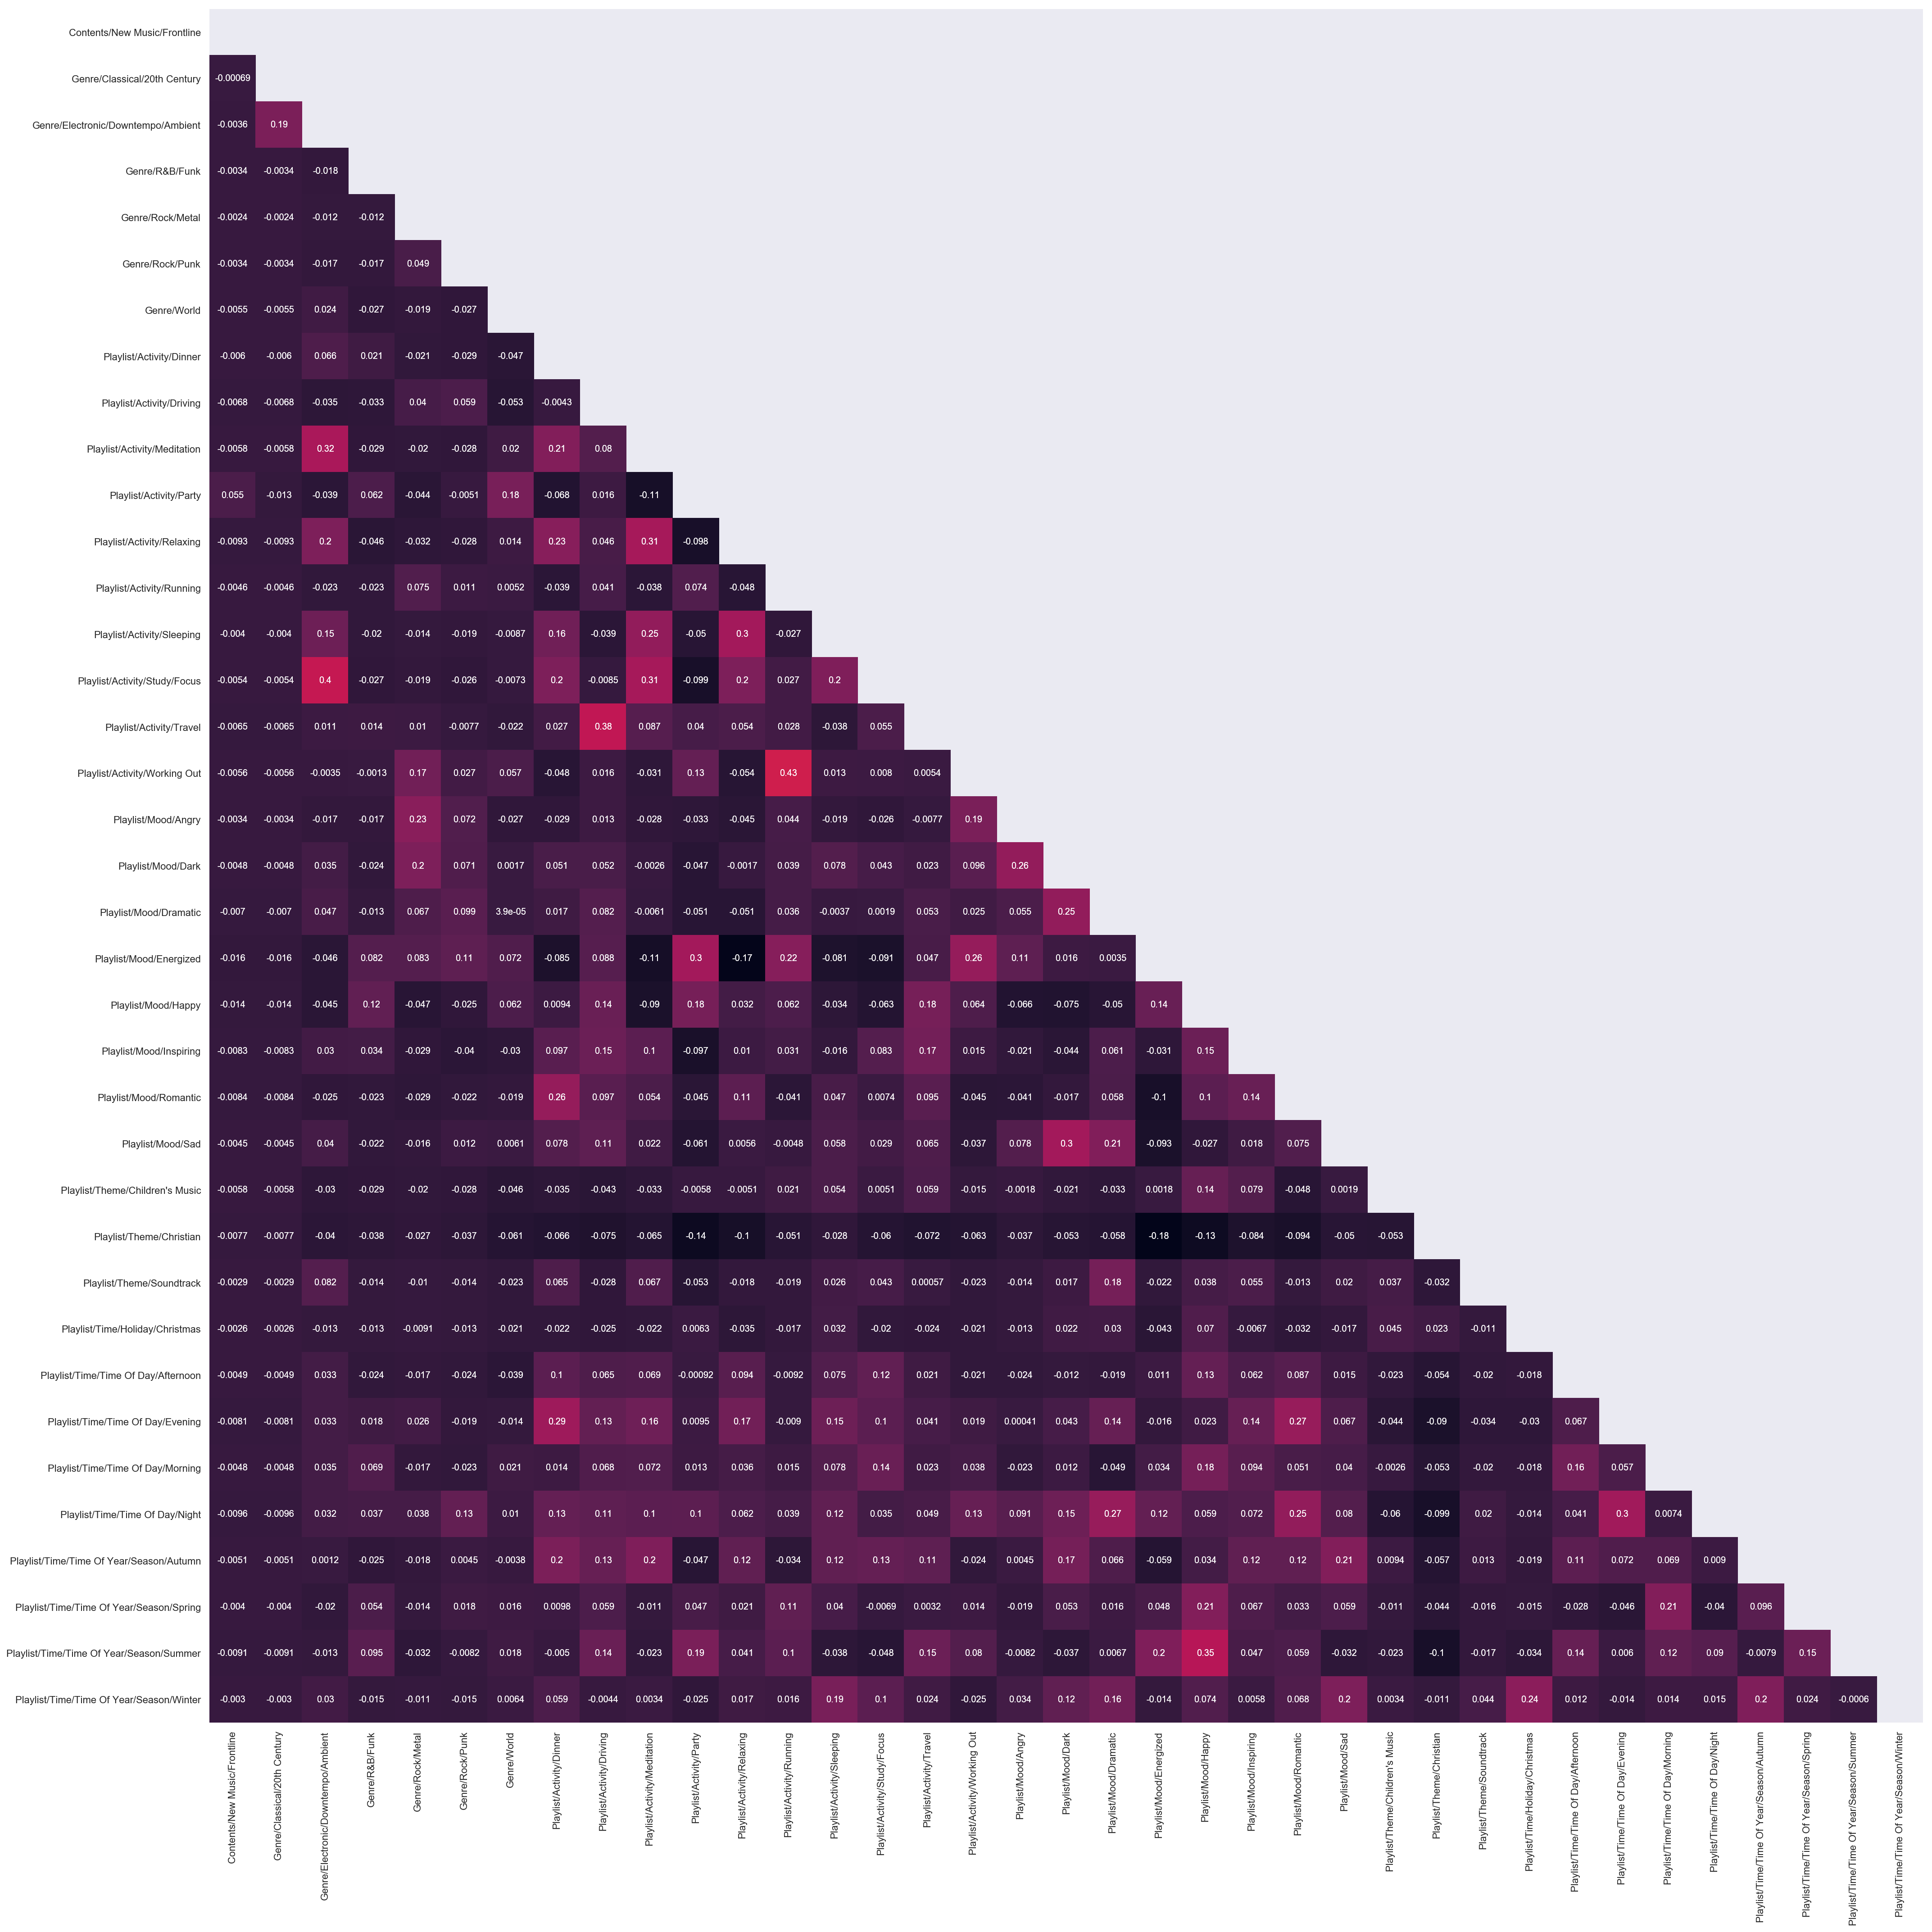

In [71]:
# Heatmap of tags

fig = plt.figure(figsize=(35,35))
ax = fig.gca()

corr=df_clust_id.corr(method='spearman')
corr_cols = corr.columns.sort_values()
corr2 = corr[corr_cols].sort_index()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(corr2, mask=mask, square=True,annot=True,cbar=False)
heatmap = sns.heatmap(corr2, mask=mask, square=True,annot=True,cbar=False)

heatmap.figure.savefig("output.png")
plt.show()

In [72]:
cols_alt = [re.findall('[a-zA-Z\s0-9-_&]+(?!.*\/)', str(x))[0] for x in df_clust_id.columns]

In [73]:
print(len(cols_alt))
print(len(set(cols_alt)))

38
38


## PCA Analysis

In [74]:
# Standardising the tag distribution before applying PCA analysis

ss = StandardScaler()
tags_st = ss.fit_transform(df_clust_id.iloc[:,1:])
df_tags_st=pd.DataFrame(tags_st,columns=df_clust_id.columns[1:], index=df_clust_id.iloc[:,0])

In [75]:
df_tags_st.shape

(1441, 37)

In [76]:
df_tags_st.head()

,Contents/New Music/Frontline,Playlist/Time/Time Of Day/Morning,Genre/Electronic/Downtempo/Ambient,Playlist/Time/Time Of Day/Afternoon,Playlist/Activity/Dinner,Playlist/Time/Time Of Day/Night,Playlist/Mood/Dramatic,Playlist/Activity/Study/Focus,Playlist/Time/Time Of Year/Season/Winter,Playlist/Activity/Working Out,...,Genre/World,Playlist/Time/Holiday/Christmas,Playlist/Activity/Travel,Playlist/Activity/Sleeping,Playlist/Mood/Dark,Playlist/Theme/Children's Music,Playlist/Mood/Energized,Playlist/Theme/Christian,Genre/Classical/20th Century,Playlist/Time/Time Of Year/Season/Summer
playlist_id,,,,,,,,,,,,,,,,,,,,,
00Ot5pBIr1CuAlAJUivoOK,-0.026352,-0.18159,-0.135553,-0.185629,-0.225959,-0.364502,-0.267162,-0.204787,-0.115592,4.676860,...,-0.208439,-0.099049,-0.247223,-0.153093,-0.18159,-0.220823,1.665008,-0.293101,-0.026352,2.890872
00e2vXzWaSmxJ1Fga6l2ug,-0.026352,-0.18159,-0.135553,-0.185629,-0.225959,-0.364502,-0.267162,-0.204787,-0.115592,-0.213819,...,-0.208439,-0.099049,-0.247223,-0.153093,-0.18159,-0.220823,1.665008,-0.293101,-0.026352,-0.345916
00ovokuQiZ1iBM5hxFqyxP,-0.026352,-0.18159,-0.135553,-0.185629,-0.225959,-0.364502,-0.267162,-0.204787,-0.115592,4.676860,...,-0.208439,-0.099049,-0.247223,-0.153093,-0.18159,-0.220823,1.665008,-0.293101,-0.026352,2.890872
00xkZo0UVb5tsXPj2I9DZz,-0.026352,-0.18159,-0.135553,-0.185629,-0.225959,2.743470,3.743049,-0.204787,-0.115592,-0.213819,...,-0.208439,-0.099049,-0.247223,-0.153093,-0.18159,-0.220823,1.665008,-0.293101,-0.026352,-0.345916
014Mr2IJhIfZFu6NLYl6nO,-0.026352,-0.18159,-0.135553,-0.185629,4.425575,-0.364502,-0.267162,-0.204787,-0.115592,-0.213819,...,-0.208439,-0.099049,-0.247223,-0.153093,-0.18159,-0.220823,1.665008,-0.293101,-0.026352,-0.345916


In [77]:
# Getting PCA with all components

tags_pca = PCA().fit(df_tags_st)
tags_pcs = tags_pca.transform(df_tags_st)
tags_pcs = pd.DataFrame(tags_pcs, 
                        columns=['PC'+str(i) for i in range(1, tags_pcs.shape[1]+1)])

tags_pcs.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37
0,-0.251531,3.360417,0.095228,2.313332,-1.471213,0.945193,-0.361370,0.691334,-0.601548,-0.510500,...,1.307173,-0.773641,0.527676,1.450147,-1.402424,-0.869108,1.801197,-0.474849,-2.961582,0.063395
1,-1.313954,0.649926,-0.119239,0.727357,-0.217839,0.712510,0.512938,-0.600930,-0.619649,-0.064191,...,0.055356,-0.053887,0.397920,-0.662778,-0.447003,0.311952,-0.070057,-0.056202,0.033757,-0.476083
2,-1.014572,3.374807,3.119072,2.778703,0.063958,-1.395191,-2.031968,0.688036,-0.160969,1.737177,...,-0.869816,-0.894807,0.966706,1.148952,-0.216951,-0.459534,2.656301,-0.505539,-0.808769,-0.159409
3,1.970617,2.859709,1.181102,-1.684543,-2.407054,0.078278,1.939990,0.075615,0.322805,0.524524,...,-1.172243,-1.531777,-2.441469,-0.312432,1.349387,-0.441633,0.651356,0.800958,0.896130,-0.479155
4,0.349964,-0.408493,-0.017647,0.275331,-0.959623,0.603386,-0.652928,0.384843,0.144646,-0.268575,...,-0.387883,2.024484,0.000342,-1.433061,0.823288,-0.291689,1.031588,0.674329,0.413798,0.441569


In [78]:
# Getting PCA with 2 components for the graph

tags_pca2 = PCA(n_components=2)
tags_pc2 = tags_pca2.fit_transform(df_tags_st)

tags_pc2

array([[-0.25067422,  3.35585642],
       [-1.3135351 ,  0.64677697],
       [-1.0152518 ,  3.37917911],
       ...,
       [-0.90110502,  5.4345478 ],
       [ 2.91516407, -0.61425174],
       [-1.36750632, -1.71669341]])

In [544]:
# Function for the Horn's parallel analysis

def horn_parallel_analysis(shape, iters=1000, percentile=95):
    pca = PCA(n_components=shape[1])
    eigenvals = []
    
    for i in range(iters):
        rdata = np.random.normal(0,1,size=shape)
        pca.fit(rdata)
        eigenvals.append(pca.explained_variance_)
    
    eigenvals = np.array(eigenvals)
    return np.percentile(eigenvals, percentile, axis=0)

tags_pa = horn_parallel_analysis(df_tags_st.shape, percentile=95)
tags_pa

array([1.41148831, 1.36443715, 1.33438177, 1.30779667, 1.28557972,
       1.26496226, 1.24650042, 1.2279029 , 1.2124392 , 1.19514076,
       1.1799732 , 1.16568394, 1.14920747, 1.13471023, 1.12121987,
       1.10684634, 1.0930903 , 1.07958164, 1.06651437, 1.05407654,
       1.04093517, 1.02812548, 1.01699377, 1.00442687, 0.99182451,
       0.97985517, 0.96782921, 0.95579527, 0.94396636, 0.93190324,
       0.92057234, 0.90879833, 0.89747104, 0.88573441, 0.87323972,
       0.86151435, 0.84980699, 0.83758778, 0.82571376, 0.81137696,
       0.79912616, 0.78633263, 0.77300823, 0.75809206, 0.7429596 ,
       0.72611394, 0.707282  ])

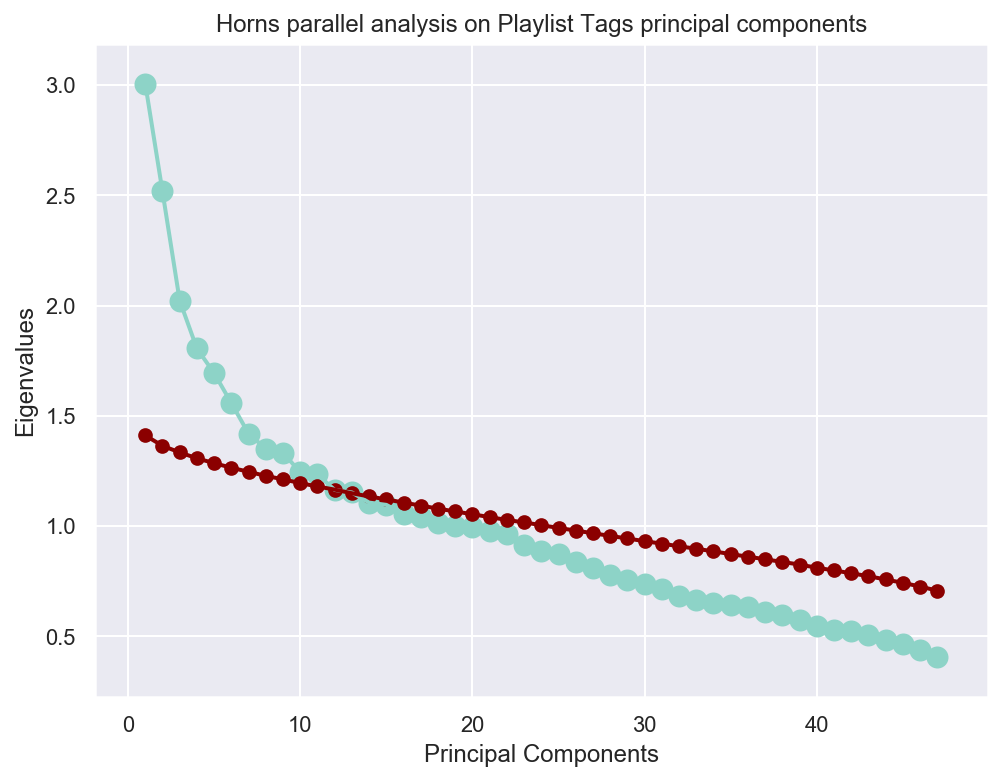

In [545]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(range(1, df_tags_st.shape[1]+1), tags_pca.explained_variance_, lw=2)
ax.scatter(range(1, df_tags_st.shape[1]+1), tags_pca.explained_variance_, s=100)

ax.plot(range(1, len(tags_pa)+1), tags_pa, lw=2, color='darkred')
ax.scatter(range(1, len(tags_pa)+1), tags_pa, s=40, color='darkred')


ax.set_title("Horns parallel analysis on Playlist Tags principal components")
ax.set_xlabel("Principal Components")
ax.set_ylabel("Eigenvalues")
plt.show()

In [546]:
tags_pa[:15]

array([1.41148831, 1.36443715, 1.33438177, 1.30779667, 1.28557972,
       1.26496226, 1.24650042, 1.2279029 , 1.2124392 , 1.19514076,
       1.1799732 , 1.16568394, 1.14920747, 1.13471023, 1.12121987])

In [547]:
tags_pca.explained_variance_[:15]

array([3.00703476, 2.51836604, 2.02280722, 1.80572901, 1.69400126,
       1.55807521, 1.41975793, 1.35096039, 1.33355146, 1.24397122,
       1.23475381, 1.16424693, 1.15271196, 1.10682218, 1.09649078])

In [548]:
tags_pca.explained_variance_ratio_[:13]

array([0.06393506, 0.05354507, 0.04300858, 0.0383931 , 0.03601757,
       0.03312753, 0.03018665, 0.02872389, 0.02835375, 0.02644911,
       0.02625313, 0.02475402, 0.02450877])

In [549]:
np.sum(tags_pca.explained_variance_ratio_[:13])

0.45725623125341364

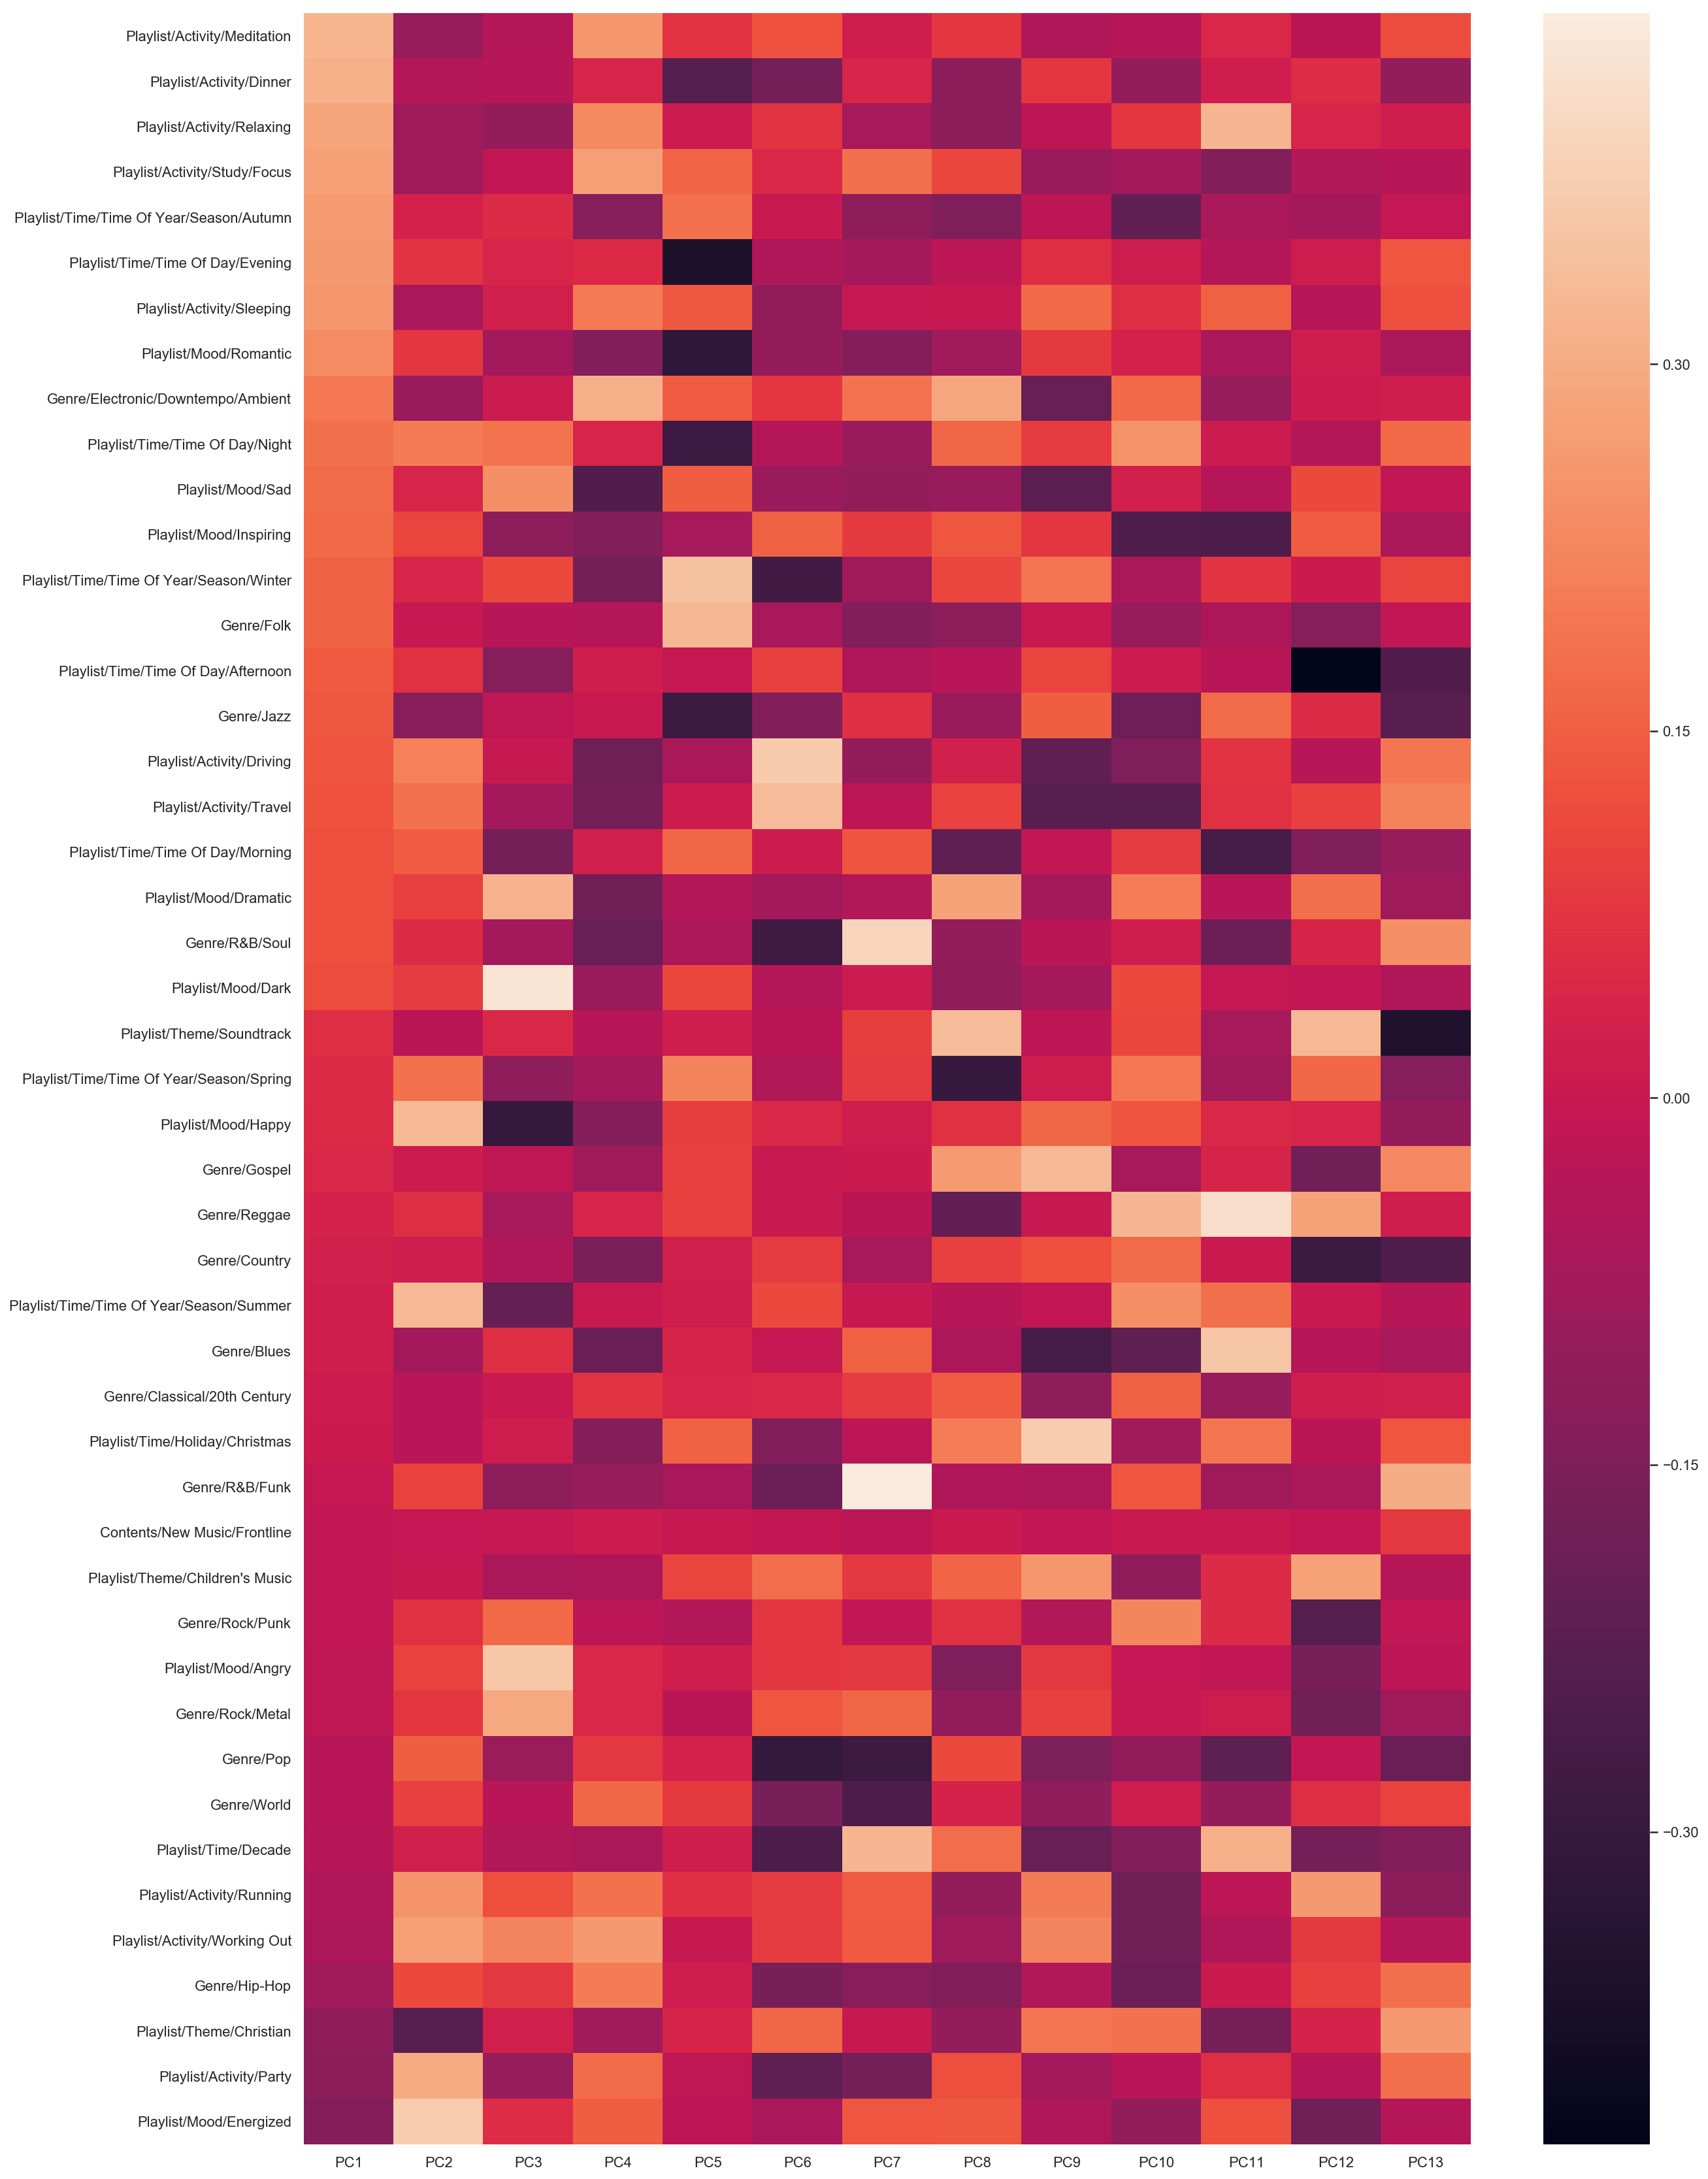

In [550]:
fig, ax = plt.subplots(figsize=(20,30))

sns.heatmap(pd.DataFrame(tags_pca.components_[0:13].T, 
                         index=df_tags_st.columns,
                         columns=['PC'+str(i) for i in range(1, 14)]).sort_values(by='PC1',ascending=False))

plt.show()

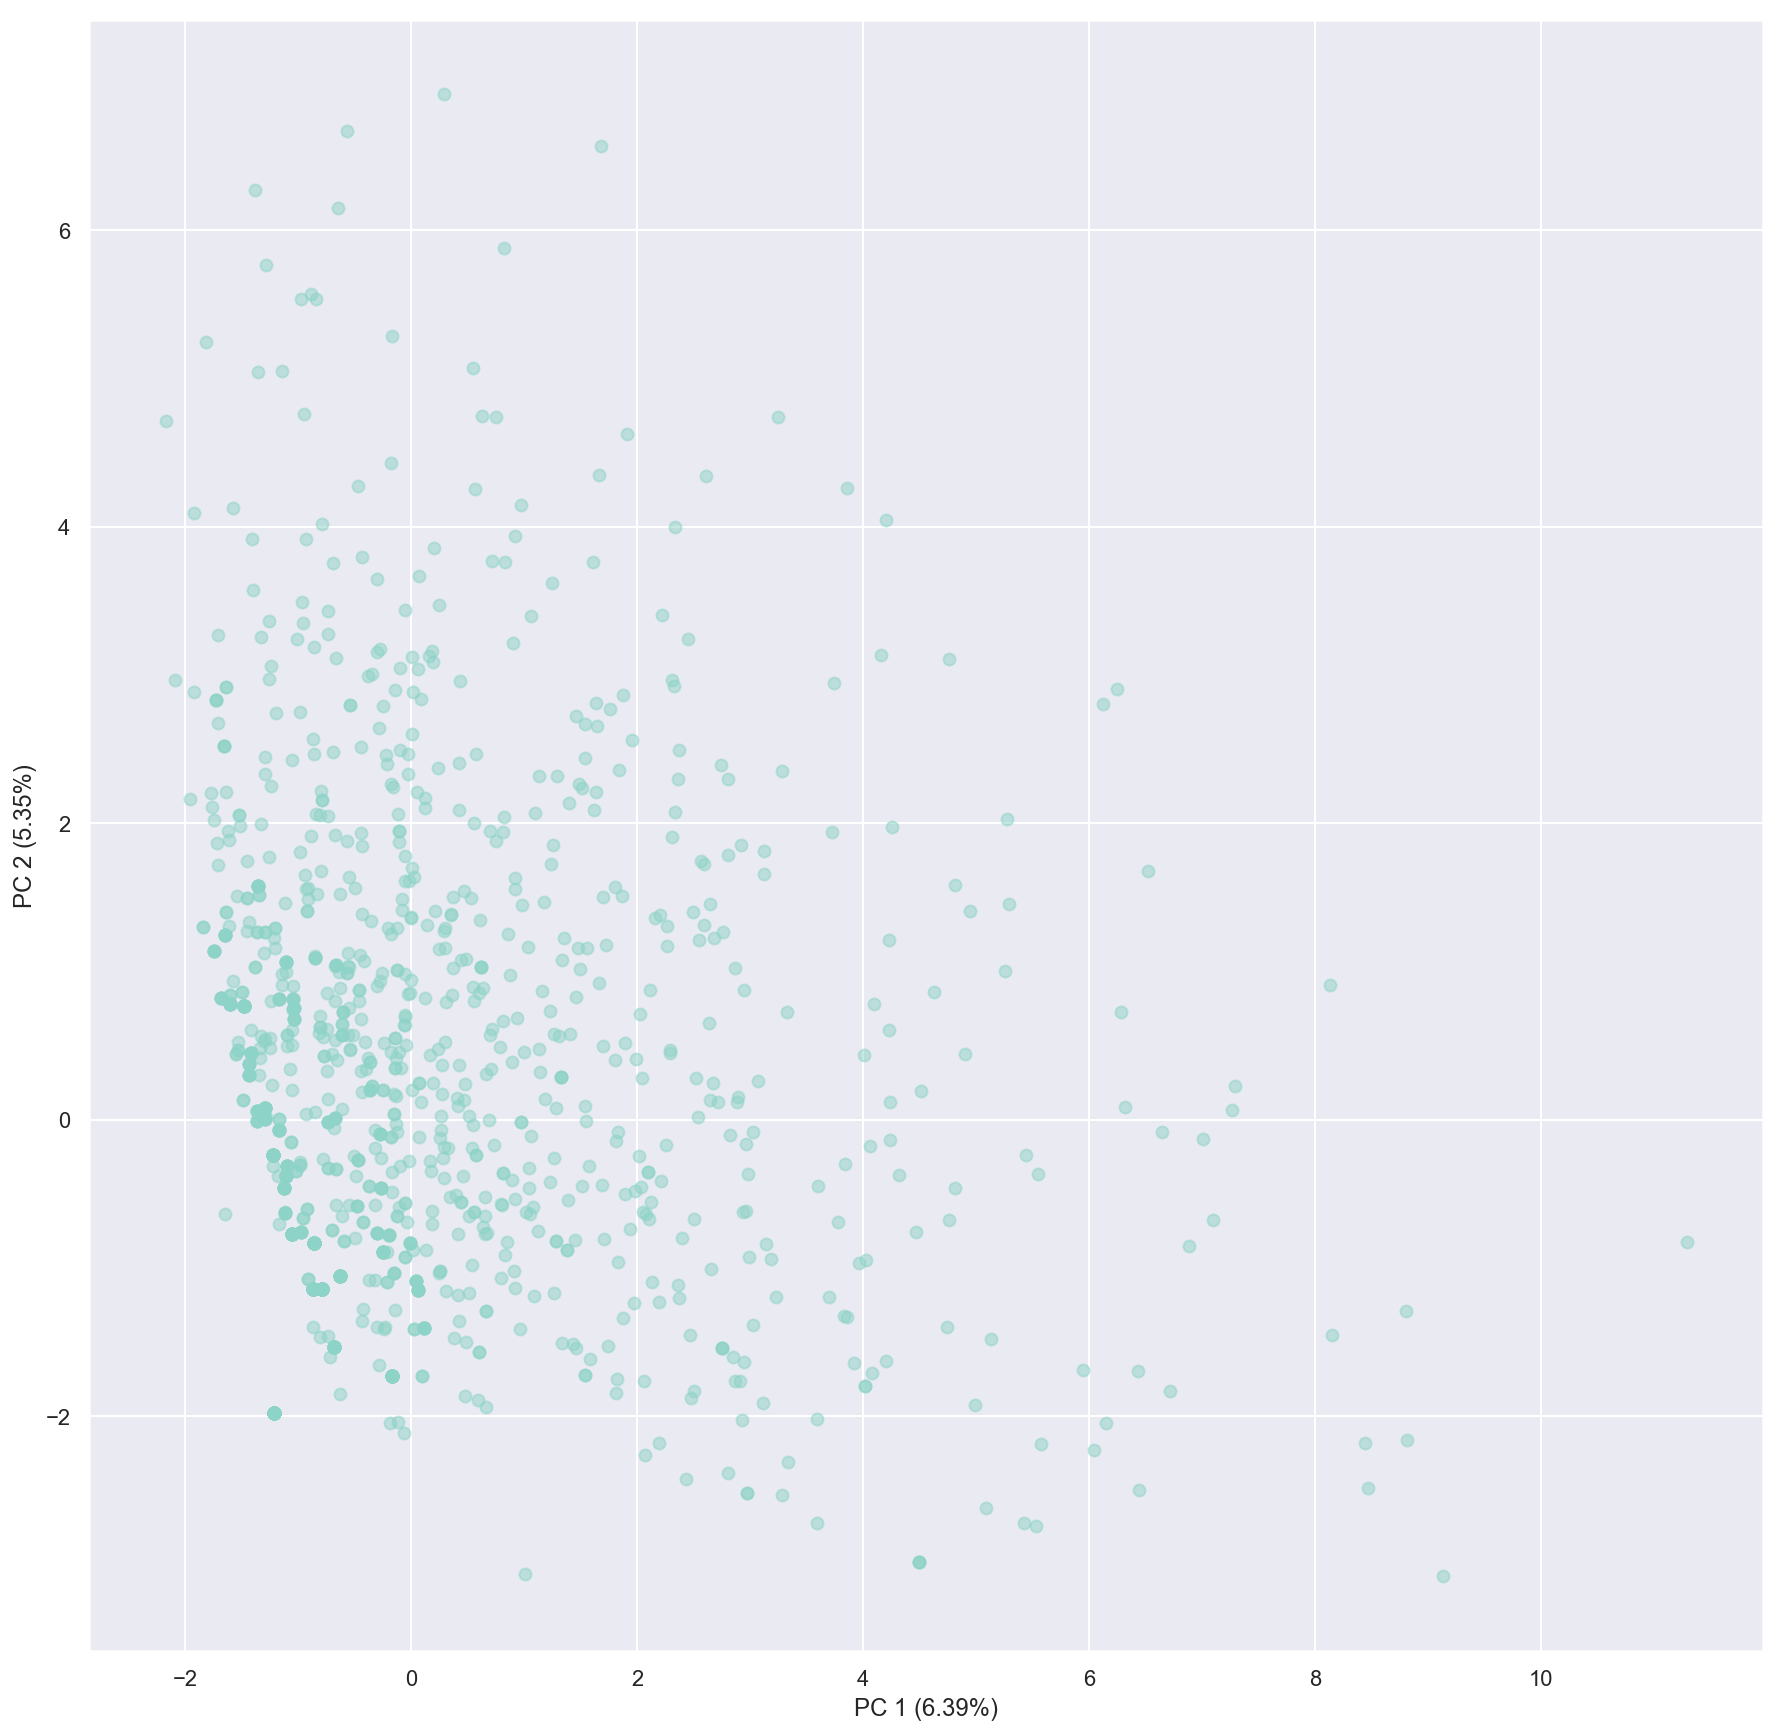

In [551]:
# Create the scatter plot
plt.figure(figsize=(15,15))
plt.scatter(tags_pc2[:,0], tags_pc2[:,1], alpha=0.5)

# Add the axis labels
plt.xlabel('PC 1 (%.2f%%)' % (tags_pca2.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (tags_pca2.explained_variance_ratio_[1]*100)) 

# Done
plt.show()

## Clustering

In [552]:
# Function to run clutering algorithms and review their output

def dbscan_tuning(df,eps_list,min_samples_list):
    
    df_res = pd.DataFrame(columns=['eps','min_sample','n_clusters','unlabelled_prop','silhouette_coeff'],
                         index = range(len(eps_list)*len(min_samples_list)))
    c=-1
    
    for i,eps_i in enumerate(eps_list):
        for j, min_j in enumerate(min_samples_list):
            
            c=c+1
            
            dbscn = DBSCAN(eps=eps_i, min_samples=min_j)
            dbscan=dbscn.fit(df)
            labels = dbscan.labels_ 
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            
            #print("epsilon, min_samples: ", eps_i, min_j)
            #print( "clusters: ", n_clusters_)
            #print("unlabelled proportion: ", float(list(labels).count(-1))/labels.shape[0])
            #print("silhouette coefficient: ", metrics.silhouette_score(df, labels))
            #print()
            
            df_res['eps'][c]=eps_i
            df_res['min_sample'][c]=min_j
            df_res['n_clusters'][c]=n_clusters_
            df_res['unlabelled_prop'][c]=float(list(labels).count(-1))/labels.shape[0]
            df_res['silhouette_coeff'][c]=metrics.silhouette_score(df, labels)
            
            
    return df_res

In [553]:
# Range of clustering parameters

eps_list=range(8,16)
min_samples_list=[2,3,4]

In [554]:
df_res = dbscan_tuning(df_tags_st,eps_list,min_samples_list)

In [555]:
df_res.head(10)

,eps,min_sample,n_clusters,unlabelled_prop,silhouette_coeff
0,8,2,10,0.0360861,0.292528
1,8,3,7,0.0402498,0.315534
2,8,4,6,0.0430257,0.313925
3,9,2,8,0.0256766,0.32163
4,9,3,7,0.0270645,0.321945
5,9,4,5,0.0312283,0.319702
6,10,2,6,0.0173491,0.388297
7,10,3,5,0.018737,0.392699
8,10,4,5,0.019431,0.392081
9,11,2,4,0.0138793,0.41863


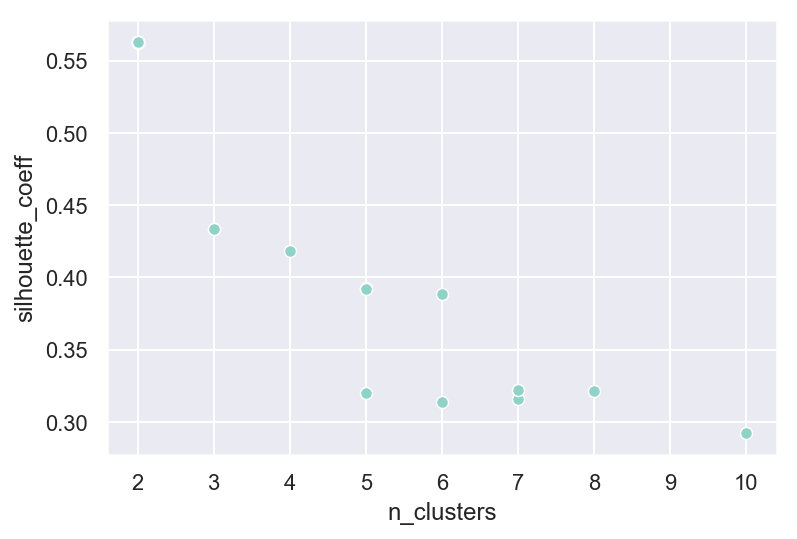

In [556]:
ax = sns.scatterplot(x="n_clusters", y="silhouette_coeff", data=df_res)

The winner is the DBSCAN with eps 10 and min_samples 2:

In [565]:
dbscn_10_2 = DBSCAN(eps=10, min_samples=2)
dbscan=dbscn_10_2.fit(df_tags_st)
labels = dbscan.labels_ 

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(df_tags_st, labels))

Silhouette Coefficient: 0.388


In [566]:
pl_clust=pd.DataFrame(zip(labels,df_tags_st.index),columns=['label','playlist_id'])
pl_clust.to_csv('playlist_clust.csv')

pl_clust.groupby('label').count().sort_values(by='playlist_id',ascending=False)

,playlist_id
label,
0,1381
-1,25
4,13
1,11
2,5
3,4
5,2


In [567]:
clust_dict={}

for i,lbl in enumerate(pl_clust['label']):
    if lbl in clust_dict.keys():
        clust_dict[lbl].append(pl_clust['playlist_id'][i])
    else:
        clust_dict[lbl]=[pl_clust['playlist_id'][i]]
        
clust_dict

{0: ['00Ot5pBIr1CuAlAJUivoOK',
  '00e2vXzWaSmxJ1Fga6l2ug',
  '00ovokuQiZ1iBM5hxFqyxP',
  '00xkZo0UVb5tsXPj2I9DZz',
  '014Mr2IJhIfZFu6NLYl6nO',
  '0156tLfZJwb6CDgXRTfzT5',
  '015H26Hfu78TZG6lAc4tSS',
  '01LrEloa2zGHxA0I8KNnWT',
  '01cMmxcvXslRy2gw5ZYzcj',
  '01yzVaVYZmcN5zC8KD49AS',
  '022SRRxqkwI7rzxprvCHXc',
  '02ES3fS2eHdLnDEuEUD60V',
  '02EgXbc34R94ezZe3sjqoy',
  '04BPAHNEj2hnAEftQftm3k',
  '04QGQDLqqhWnTyY7peE4o2',
  '04hOL4cJstu4DyJJLuinMT',
  '055xSrqh5OJmlZryiCaj0y',
  '05BPX0BFVvdrNLlSHiTTPA',
  '05lr5JlZRRgMb5wy4ptO3j',
  '05n4Z4Up6zknsIsoklyUmN',
  '06I4eUFA4TpvFExL5CuH86',
  '06K9bQi63QEqyrPFeEMm3d',
  '06Kff3jXCpcy3SIZsRAaN5',
  '06LsCWA0CN40Z9wmoMou77',
  '06kq6UEHx5P4NhsmG4rmjZ',
  '06m5HzAGIkYyLsDdNpWoCp',
  '07TYO8N5n2xj475OJHYvbi',
  '07p4ZdkIDMuexx1OnkZ14q',
  '08CJ6fWrTA1vMfwVwAxWUl',
  '08h4uqVS5e0TldnETHxfDp',
  '09FFsDV9TiZNPjnqT9kshJ',
  '09aiClP3EzfuHVuw5m8CNr',
  '09cPJv64hnG1oRujTULEnV',
  '09dQousRkMacoGsx1XVbWP',
  '0A06WmiRHgp1h6YPbhVkA6',
  '0A1eAERTv44QNH

In [568]:
pl_clust.to_gbq(project_id='umg-comm-tech-dev', if_exists='replace', 
                destination_table='playlist_sequencing.dbscan_clusters')

1it [00:03,  3.36s/it]


In [569]:
clust_and_meta_sql = """
SELECT
  label,
  playlist_id,
  MAX(name) AS name,
  MAX(e.parent_brand) AS parent_brand,
  MAX(brand) AS brand,
  MAX(playlist_description) AS description,
  MAX(playlist_owner) AS user,
  MAX(follower_count) AS n_followers
FROM
  `umg-comm-tech-dev.playlist_sequencing.dbscan_clusters` c
LEFT JOIN
  `umg-comm-tech-dev.playlist_sequencing.create_export` e
ON 
  c.playlist_id=e.spotify_id  
LEFT JOIN
  `umg-edw.spotify.playlist_history`
USING
  (playlist_id)
GROUP BY
  label,
  playlist_id
"""

In [570]:
clust_and_meta = gbq.read_gbq(clust_and_meta_sql, project_id='umg-comm-tech-dev', dialect='standard')
clust_and_meta.shape

(1441, 8)

In [571]:
clust_and_meta.head()

,label,playlist_id,name,parent_brand,brand,description,user,n_followers
0,4,1lHFMga7bSawG2wI4nsiaJ,Gotta Love Christmas,None,uDiscover,None,None,NaN
1,0,4h4yewBqhRhGtXjhXGwloF,Sleep Sound,None,Sozo,Sleep to the soothing sounds of nature. Click ...,sozoofficial,905.0
2,0,3NSwYPs0boNCF2YXLosPMw,THIS IS EDM,None,THIS IS,"The biggest electronic tracks in the world, al...",thisisofficial,5931.0
3,0,1NM9DxNxI6ev1W1bzSZ1j2,Best Picture - Oscar Nominations,None,uDiscover,None,None,NaN
4,0,1u1bGCt5meXFmnd77HkR5R,Dalida Best Of,Digster,Digster FR,"Dalida, une star internationale et intemporell...",digster.fr,10699.0


## Investigating clusters


####  Cluster number 4 seems to be Christmas

In [572]:
clust_and_meta[clust_and_meta.label==4]

,label,playlist_id,name,parent_brand,brand,description,user,n_followers
0,4,1lHFMga7bSawG2wI4nsiaJ,Gotta Love Christmas,None,uDiscover,None,None,NaN
124,4,7iMyUkmPe7epyb8J1mqT9y,Christmas Music,Digster,Digster FM,Turn up the joy in time for Christmas. However...,universal.fm,339510.0
218,4,6mIRMg8kpuok7eS3o7uUx7,Christmas Country,Digster,Digster FM,The best Country Christmas songs!,digster.fm,15238.0
230,4,4ObeA5hqPSnCyPMaszMlOD,None,None,None,There goes Halloween. Here comes Christmas! Li...,digster.fm,11613.0
352,4,1FR1VsWKhbMHXZcJshf9OQ,JULEHITS - Julesange du elsker - Julemusik ti...,Digster,Digster DK,På Digster JULEHITS fejrer vi jul på fineste m...,digster.dk,34964.0
488,4,2gUU4fiNI1Fuu1FWcR7uQh,Have Yourself a Jazz Christmas,None,uDiscover,"<a href=""http://www.udiscovermusic.com"">uDisco...",udiscover,5586.0
839,4,30zIqHLjwPVDyXwxduVZCB,Christmas Rock,Digster,Digster FM,Simply all the Hunger Games Soundtracks in one...,digster.fm,38180.0
884,4,1A4meEJ1VUbnHhIxzfC17M,Digster CHRISTMAS SWING,None,Digster CH,The fluffiest Jazzy Christmas tracks for a coz...,digsterdeutschland,2204.0
956,4,7GY66rE4X1P0zsE1Fv3AyD,'Louie Louie' In 20 Takes,None,uDiscover,None,None,NaN
1066,4,5lTy3w4iZbOAdJPWV7fEN5,Have Yourself a Blues Christmas,None,uDiscover,"<a href=""http://www.udiscovermusic.com"">uDisco...",udiscover,1234.0


####  Cluster number 1 is Metal

In [575]:
clust_and_meta[clust_and_meta.label==1]

,label,playlist_id,name,parent_brand,brand,description,user,n_followers
57,1,5OjMsLblKP5Uwt0MVvab8X,Thrash Metal History,None,uDiscover,None,None,NaN
107,1,5sgb06XdH7xlziL0WFQDh0,Metal Supreme,Digster,Digster DE,"The must knows and hidden gems of Heavy Metal,...",digsterdeutschland,892.0
119,1,0RO49mStzTTVIMY05mZLi0,KISS Best Of,Artist Playlists,Artist Playlists,The most played KISS tracks on Spotify right n...,kissofficial,16911.0
281,1,028qeaDokT41qHkYsLjj4L,None,None,None,None,None,NaN
605,1,2XCVclMJGst61jUTQV03Pw,Heavy Metal,None,uDiscover,None,None,NaN
651,1,7LGt8neoUvB8Lx102zifgY,Def Leppard Best Of,Artist Playlists,Artist Playlists B,Def Leppard is officially a nominee for the 20...,defleppardofficial,12211.0
783,1,4OKGv1qIxrx1qNWNRrqMei,Heavy Metal Thunder,None,uDiscover,None,None,NaN
840,1,5xuqf6dO4vRAYKNCLsN4Tl,Slayer Digging Deeper,None,uDiscover,None,None,NaN
953,1,1GZXuUa6quNgFbMdNCqiBl,Metal Heroes,Digster,Digster IT,None,None,NaN
1098,1,7vyY1k0tY8cOgCYbsQIatf,Metal,Digster,Digster FM,"The best damn <a href=""http://www.digster.fm/r...",digster.fm,28878.0


####  Cluster number 3 is Latin Gospel and couple of individual artists

In [573]:
clust_and_meta[clust_and_meta.label==3]

,label,playlist_id,name,parent_brand,brand,description,user,n_followers
475,3,3jk3N2djR4L0vjHOHiK3xS,Nina Simone Digging Deeper,None,uDiscover,None,None,NaN
728,3,0zj2gg4UXElb5WEtTUEVza,Gospel - Músicas Para Louvar,Digster,Digster BR,As canções que irão tocar seu coração e renova...,digster_brasil,12453.0
989,3,2eunS7LyIkskRiYoferrHL,The Statler Brothers Digging Deeper,None,uDiscover,None,None,NaN
1216,3,18bBGR0C3cVXNDEcqEtXab,Sertanejo Gospel,Digster,Digster BR,None,None,NaN


####  Cluster number 2 is Italian and Sad Music

In [574]:
clust_and_meta[clust_and_meta.label==2]

,label,playlist_id,name,parent_brand,brand,description,user,n_followers
790,2,4Ytfn72jrbw514hfSDyEJ2,Melancholia,None,Digster CH,"Runterfahren, anhalten, ankommen - die Playlis...",digsterdeutschland,7883.0
987,2,0ieRWquYaE5uf3XvbPxsi5,Elliot Smith Digging Deeper,None,uDiscover,None,None,NaN
1099,2,5tpOGa8unbNqxC14TNJGju,Italia In Viaggio,Digster,Digster IT,Tutta la migliore musica italiana.Viva l'Itali...,digster_italy,22125.0
1141,2,5VbqrmM5inoyJmpBIi8r7L,Mai Na Gioia,Digster,Digster IT,None,None,NaN
1155,2,3m63xTSCvzPOUB042OO6I7,Winter Vibes,Digster,Digster IT,Hot Tracks for Cold Cold days. the real best o...,digster_italy,514.0


Autumn and Evening music?

In [576]:
clust_and_meta[clust_and_meta.label==5]

,label,playlist_id,name,parent_brand,brand,description,user,n_followers
361,5,6gyx12h3zxFS6fhE5RWbQh,Autumn Vibes,Digster,Digster IT,Questo autunno non sarà triste con la musica g...,digster_italy,2874.0
1277,5,5x5VBLpyTHxwOGjmN7KCPX,Swag.com,Digster,Digster IT,Aggiornata ogni settimana con le nuove uscite ...,digster_italy,1940.0


## Trying Affinity Propagation clustering

In [140]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

In [141]:
X = df_tags_st.copy()

In [146]:
af = AffinityPropagation(verbose=True).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels,
#                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

Did not converge
Estimated number of clusters: 221
Silhouette Coefficient: -0.035
